# Image Classification with TensorFlow

Image classification is a common task for deep learning and neural networks.  The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining whether an image is of a cat.  Older methods used a lot of clever filters, but the current best-of-breed algorithms simply throw a lot of linear algebra at the problem.

In this project, we build a series of models to classify a series of images into one of ten classes. 

## Downloading and processing the data

We consider the CIFAR-10 data set (https://www.cs.toronto.edu/~kriz/cifar.html). The data set is already converted to numpy arrays. For every practical purposes, we will have a set of PNG images. 

Therefore here we describe the process of the converting a set of PNG images to numpy array first. We download the same set of PNG images from 
https://www.kaggle.com/datasets/swaroopkml/cifar10-pngs-in-folders

The directory contains sub-directories which contain the images of a particular class like Airplane, Bird, Cat ...


In [1]:
from PIL import Image
import numpy as np
import os
import multiprocessing

The human readable names are

In [2]:
labels = list(os.walk("./archive/cifar10/cifar10/train/"))[0][1]
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
from multiprocessing import pool
Pool = pool

In [45]:

image_dir = "./archive/cifar10/cifar10/train/"
train_data = []

# Loop through the image files in the directory
for i in range(10):
    for filename in os.listdir(image_dir+labels[i]):
        image = Image.open(os.path.join(image_dir+labels[i], filename))

        image_array = np.array(image)

        train_data.append(image_array)

train_data = np.array(train_data)

In [46]:
image_dir = "./archive/cifar10/cifar10/test/"
test_data = []

# Loop through the image files in the directory
for i in range(10):
    for filename in os.listdir(image_dir+labels[i]):
        image = Image.open(os.path.join(image_dir+labels[i], filename))

        image_array = np.array(image)

        test_data.append(image_array)

test_data = np.array(test_data)

In [47]:
train_labels = np.hstack([np.ones(5000)*i for i in range(10)])
test_labels = np.hstack([np.ones(1000)*i for i in range(10)])

In [60]:
# Now reshuffle the images randomly
import random
temp = list(zip(train_labels,train_data))
random.shuffle(temp)
train_labels,train_data = zip(*temp)
train_labels,train_data = np.array(train_labels), np.array(train_data)

temp = list(zip(test_labels,test_data))
random.shuffle(temp)
test_labels,test_data = zip(*temp)
test_labels,test_data = np.array(test_labels), np.array(test_data)

Let's check if the images are properly imported in the numpy array. Check the 10286th image.

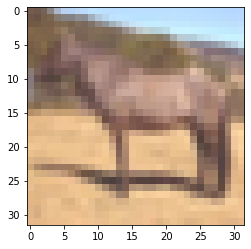

In [61]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_data[10286,:,:,:])

In [62]:
labels[int(train_labels[10286])]

'horse'

In [41]:
import tensorflow as tf
from tensorflow import keras

In [64]:
y_train = tf.one_hot(train_labels,10)
y_test = tf.one_hot(test_labels,10)

In [14]:
model = tf.keras.models.Sequential()

In [15]:
model.add(tf.keras.layers.Conv2D(32, [5,5],strides=1, activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(tf.keras.layers.Conv2D(32, [5,5],strides=1, activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

In [17]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256,activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(256,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))

In [18]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [65]:
model.fit(train_data,y_train, epochs=12, batch_size=50, validation_data=(test_data,y_test))

Epoch 1/12
1000/1000 [==============================] - 27s 27ms/step - loss: 2.4985 - accuracy: 0.2103 - val_loss: 1.8658 - val_accuracy: 0.3255
Epoch 2/12
1000/1000 [==============================] - 27s 27ms/step - loss: 1.7802 - accuracy: 0.3509 - val_loss: 1.5538 - val_accuracy: 0.4479
Epoch 3/12
1000/1000 [==============================] - 27s 27ms/step - loss: 1.5603 - accuracy: 0.4364 - val_loss: 1.4838 - val_accuracy: 0.4605
Epoch 4/12
1000/1000 [==============================] - 27s 27ms/step - loss: 1.4440 - accuracy: 0.4809 - val_loss: 1.3408 - val_accuracy: 0.5219
Epoch 5/12
1000/1000 [==============================] - 27s 27ms/step - loss: 1.3545 - accuracy: 0.5211 - val_loss: 1.2679 - val_accuracy: 0.5482
Epoch 6/12
1000/1000 [==============================] - 27s 27ms/step - loss: 1.2890 - accuracy: 0.5443 - val_loss: 1.2369 - val_accuracy: 0.5695
Epoch 7/12
1000/1000 [==============================] - 27s 27ms/step - loss: 1.2256 - accuracy: 0.5705 - val_loss: 1.1829 -

## Transfer Learning

In transfer learning, we use a network trained on one data set to provide a starting point for the modeling of other data.  As we are trying to model color images, we should look for another network trained on color images. 

The following cell will load the model, omitting its classification layer (since we're not interested in classifying `ImageNet` images).

In [66]:
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer

96112376/96112376 [==============================] - 47s 0us/step
